In [32]:
# write by hy in 2023/9/5
import os.path
import os
import cv2 as cv
import numpy as np

class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]
    
def net_hsd():
    cv.dnn_registerLayer('Crop', CropLayer)
    
    # Load the model.
    prototxt = r'D:\qk_maskrcnn_trs\edge_det\deploy.prototxt'
    caffemodel =r'D:\qk_maskrcnn_trs\edge_det\hed_pretrained_bsds.caffemodel'
    net = cv.dnn.readNet(prototxt, caffemodel)
    return net

In [ ]:
import matplotlib.pyplot as plt
class Crop2bin_img(object):
    # 图片剪裁，筛选阈值，保存预轮廓
    def __init__(self, img_path, scale):
        self.img_path = img_path
        self.img = cv.imread(img_path)
        self.scale = scale
    
    def stat_img(self, show_img = False):
        # 对图片进行统计，选择合适的阈值
        stat_dict = {}
        img_bin = self.img[..., 0]
        img_max = np.max(img_bin)
        img_min = np.min(img_bin)
        img_std = np.std(img_bin)
        img_mean = np.mean(img_bin)
        stat_dict['max'] = img_max
        stat_dict['min'] = img_min
        stat_dict['std'] = img_std
        stat_dict['mean'] = img_mean
        stat_dict['shape'] = img_bin.shape
        lower_limit = img_mean - self.scale * img_std
        upper_limit = img_mean + self.scale * img_std
        if show_img == True:
            print('img shape is {0}'.format(self.img.shape))
            plt.hist(img_bin)
            plt.show()
        return stat_dict, [lower_limit, upper_limit]
        
    def filter_pixel(self):
        img_bin = self.img[...,0]
        mask = np.zeros_like(img_bin)
        lower, upper = self.stat_img()[1]
        keep = np.where((lower < img_bin) & (img_bin < upper))
        mask[keep] = 255
        mask_gary = mask[..., None]
        img_gray = img_bin[..., None]
        mask_3d = np.concatenate([mask_gary] * 3, axis = 2)
        img_3d = np.concatenate([img_gray] * 3, axis = 2)
        return mask_3d, img_3d
    
    def con_mask_img(self):
        mask, img = self.filter_pixel()
        self.mask = mask
        con = np.concatenate([mask, img], axis = 1)
        plt.imshow(con, interpolation = 'bilinear')
        return con, mask, img 
        
    def save_mask3d(self, save_path):
        self.con_mask_img()
        plt.imshow(self.mask, interpolation = 'bilinear')
        main_name = self.img_path.split('\\')[-1].split('.')[0] + '.jpg'
        if save_path:
            if os.path.exists(save_path) is False:
                os.makedirs(save_path)
        file_path = os.path.join(save_path, main_name)
        cv.imwrite(file_path, self.mask)
        
    def __call__(self):
        assert self.filter_pixel()[0].shape[0:2] == self.stat_img()[0]['shape'], 'image shape has error'

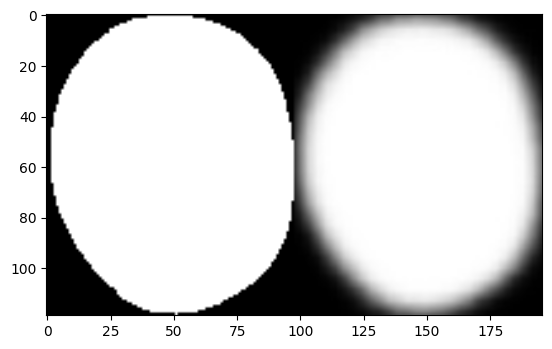

In [26]:
def main_det(img_path, net, save_path = None, is_show = False, concat = False):
    # HSD算法的边缘检测
    Name = 'qk_Edge_Detection'
    img  = cv.imread(img_path)
    # cv.namedWindow(Name, cv.WINDOW_AUTOSIZE) # Create a window using the flag CV_WINDOW_AUTOSIZE
    inp = cv.dnn.blobFromImage(img, scalefactor = 1.0, size = (500, 500),
                                mean = (104.00698793, 116.66876762, 122.67891434),
                                swapRB = False, crop = False)
    
    net.setInput(inp) ## 初始化网络
    out = net.forward() ## 计算预测值
    out = out[0, 0]
    out = cv.resize(out, (img.shape[1], img.shape[0]))
    assert out.shape == img.shape[0 : 2], '不对头'
    out = cv.cvtColor((255 * out).astype(np.uint8), cv.COLOR_GRAY2BGR)
    if concat == True:
        con = np.concatenate((img, out), axis = 1)
    else:
        con = out
    if is_show == True:
        cv.imshow(Name, con)
        cv.waitKey(0)
        cv.destroyAllWindows()
    if save_path:
        if os.path.exists(save_path) is False:
            os.makedirs(save_path)
        file_name = img_path.split('\\')[-1].split('.')[0] + '_' + 'edge' + '.jpg'
        file_path = os.path.join(save_path,file_name) 
        cv.imwrite(file_path, con)

['b1_1_v2_0_mask.jpg', 'b1_1_v2_1_mask.jpg', 'b1_1_v2_2_mask.jpg']
C:\Users\byx\Desktop\qk_maskrcnn_trs\edge_det\crop_mask\b1_1_v2_0_mask.jpg
C:\Users\byx\Desktop\qk_maskrcnn_trs\edge_det\crop_mask\b1_1_v2_1_mask.jpg
C:\Users\byx\Desktop\qk_maskrcnn_trs\edge_det\crop_mask\b1_1_v2_2_mask.jpg
C:\Users\byx\Desktop\qk_maskrcnn_trs\edge_det\dege
C:\Users\byx\Desktop\qk_maskrcnn_trs\edge_det\dege
C:\Users\byx\Desktop\qk_maskrcnn_trs\edge_det\dege


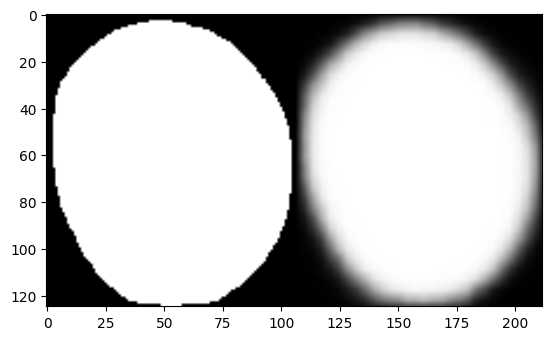

In [31]:
def main(img_path, save_mask3d_path, save_edge_path):
    imgs = os.listdir(img_path)
    print(imgs)
    for img in imgs:
        img_path1 = os.path.join(img_path, img)
        print(img_path1)
        filter = Crop2bin_img(img_path = img_path1, scale = 0.9)
        filter.save_mask3d(save_path = save_mask3d_path)
        filter.con_mask_img()
    for mask in os.listdir(save_mask3d_path):
        file = os.path.join(save_mask3d_path, mask)
        main_det(img_path = file,net=net, 
         save_path = save_edge_path, is_show=True)
        print(save_edge_path)
    